In [1]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

X_mnist_train = x_train.reshape((len(x_train), 28, 28, 1))
X_mnist_test = x_test.reshape((len(x_test), 28, 28, 1))

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Defining a discriminator
High level explanation of a discriminator is simple classifier whose job is to differentiate between real and fake MNIST digits. Fake images being from our generator

* Instead of using Max/AvgPooling layers increased stride acts as a downsampler

In [2]:
from keras.layers import Input, Dense, Conv2D, LeakyReLU, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam

def discriminator_model(input_shape = (28, 28, 1)) -> Model:
    
    network_input = Input(shape=input_shape)
    
    layer = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(network_input)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.4)(layer)
    layer = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.4)(layer)
    layer = Flatten()(layer)
    layer = Dense(1, activation='sigmoid')(layer)
    
    model = Model(network_input, layer)
    
    adam = Adam(lr=0.0002, beta_1=0.5)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

discriminator = discriminator_model()
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
__________

## Generating a REAL + FAKE dataset
MNIST dataset gave us real images, but our model requires fake models to differentiate from real ones

In [3]:
def generate_real_samples(dataset: np.ndarray, n_samples: int) -> (np.ndarray, np.ndarray):
    
    random_sample_indexes = np.random.randint(0, dataset.shape[0], n_samples)
    random_samples = x_train[random_sample_indexes]
    
    random_samples = random_samples.reshape((n_samples, 28, 28, 1))
    
    return (random_samples, np.ones((n_samples, 1)))


def generate_fake_samples(n_samples: int) -> (np.ndarray, np.ndarray):
    
    X = np.random.rand(28 * 28 * n_samples)
    X = X.reshape((n_samples, 28, 28, 1))
    
    return (X, np.zeros((n_samples, 1)))

In [4]:
import matplotlib.pyplot as plt

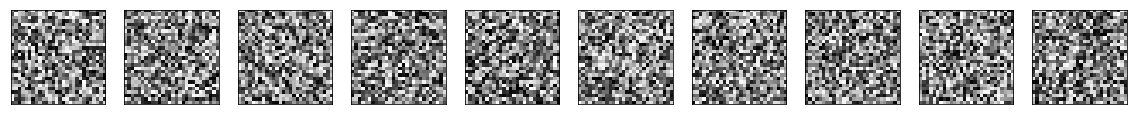

In [5]:
fake_images, _ = generate_fake_samples(10)

plt.figure(figsize=(20, 20))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(fake_images[i].reshape((28, 28)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## About the discriminator
* Since we defined the architecture of the discriminator we are going to train it sequentaly with the whole GAN, not by itself

## Defining a generator

In [57]:
from keras.layers import Reshape, Conv2DTranspose, MaxPool2D

In [7]:
def generator_model(latent_dim: int) -> Model:
    
    network_input = Input(shape=(latent_dim,))
    
    layer = Dense(128 * 7 * 7)(network_input)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Reshape((7, 7, 128))(layer)
    layer = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(layer)
    
    model =  Model(network_input, layer)
        
    return model

In [128]:
def wide_generator_model(latent_dim: int) -> Model:
    
    network_input = Input(shape=(latent_dim,))
    
    layer = Dense(512 * 7 * 7)(network_input)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Reshape((7, 7, 512))(layer)
    layer = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(layer)
    
    model =  Model(network_input, layer)
        
    return model

In [129]:
def shallow_generator_model(latent_dim: int) -> Model:
    
    network_input = Input(shape=(latent_dim,))
    
    layer = Dense(128 * 7 * 7)(network_input)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Reshape((7, 7, 128))(layer)
    layer = Conv2DTranspose(128, (4, 4), strides=(4, 4), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(layer)
    
    model =  Model(network_input, layer)
        
    return model

In [130]:
generator = wide_generator_model(100)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 25088)             2533888   
_________________________________________________________________
leaky_re_lu_193 (LeakyReLU)  (None, 25088)             0         
_________________________________________________________________
reshape_45 (Reshape)         (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d_transpose_135 (Conv2D (None, 14, 14, 256)       2097408   
_________________________________________________________________
leaky_re_lu_194 (LeakyReLU)  (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_136 (Conv2D (None, 28, 28, 256)       1048832   
__________

In [31]:
def generate_latent_points(latent_dim: int, n_samples: int) -> np.ndarray:
    
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    
    return x_input

In [32]:
def generate_fake_generator_samples(generator: Model, latent_dim: int, n_samples: int) -> (np.ndarray, np.ndarray):
    
    x_input = generate_latent_points(latent_dim, n_samples)
    
    X = generator.predict(x_input)
    
    y = np.zeros((n_samples, 1)) # Zeros because we want to convince the generator that these are fakes
    
    return X, y

### Initial generator examples

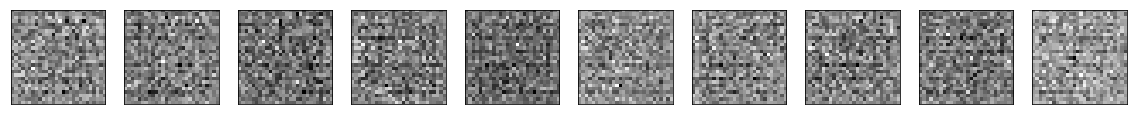

In [33]:
initial_generator_samples, _ = generate_fake_generator_samples(generator, 100, 10)

plt.figure(figsize=(20, 20))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(initial_generator_samples[i].reshape((28, 28)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Defining a GAN

In [34]:
from keras.models import Sequential

In [35]:
def define_gan(g_model: Model, d_model: Model) -> Model:
    
    d_model.trainable = False
    
    model = Sequential()
    
    model.add(g_model)
    
    model.add(d_model)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [36]:
gan_model = define_gan(generator, discriminator)
gan_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_10 (Model)             (None, 28, 28, 1)         902017    
_________________________________________________________________
model_1 (Model)              (None, 1)                 40705     
Total params: 942,722
Trainable params: 902,017
Non-trainable params: 40,705
_________________________________________________________________


## Training the GAN model

In [37]:
def test_generator(generator: Model, data: np.ndarray):
    
    generator_output = generator.predict(data)
    plt.figure(figsize=(20, 20))
    for i in range(10):
        ax = plt.subplot(1, 10, i + 1)
        plt.imshow(generator_output[i].reshape((28, 28)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [38]:
print(f'Disc metrics: {discriminator.metrics_names}')
print(f'GAN metrics: {gan_model.metrics_names}')

Disc metrics: ['loss', 'acc']
GAN metrics: ['loss', 'acc']


### Setting up tensorboard

In [39]:
from keras.callbacks import TensorBoard, Callback
import tensorflow as tf
import io

In [40]:
class image_writer(Callback):
    
    def __init__(self, log_dir: str, latent_dim: int):
        self.noise = generate_latent_points(latent_dim, 5)
#         self.file_writer = tf.summary.FileWriter(log_dir)
        self.log_dir = log_dir
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch % 5 != 0:
            return
        
        epoch_output = self.model.predict(self.noise)
        
        figure = plt.figure(figsize=(25, 5))
        for i in range(5):
            ax = plt.subplot(1, 10, i + 1)
            plt.imshow(epoch_output[i].reshape((28, 28)))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.savefig(f'{self.log_dir}/generated_digits_{epoch}.png', bbox_inches='tight')

In [41]:
def tensorboard(log_dir, batch_size: int, model: Model) -> TensorBoard:
    
    _tensorboard = TensorBoard(log_dir=log_dir,
                               histogram_freq=0,
                               batch_size=batch_size,
                               write_graph=True, 
                               write_grads=True)
    
    _tensorboard.set_model(model)
    
    print(f'Initialized Tensorboard with logdir={log_dir}')
    
    return _tensorboard



def named_logs(model: Model, logs) -> dict:
    # Creates a dictionary mapping model metrics to log data
    # eg. for GAN metrics are ['loss', 'acc'], so logs should be eg. [0.23, 0.95]
    
    result = {}
    
    for metric, value in zip(model.metrics_names, logs):
        result[metric] = value
    
    return result

def named_logs(metrics: list, logs: list) -> dict:
    # Creates a dictionary mapping metrics to log data
    # eg. for GAN metrics are ['loss', 'acc'], so logs should be eg. [0.23, 0.95]
    
    result = {}
    
    for metric, value in zip(metrics, logs):
        result[metric] = value
    
    return result

def s_named_logs(metrics:list, logs: list) -> str:
        
        logs = named_logs(metrics, logs)
        
        return ', '.join([f'{key}: {val}' for key, val in logs.items()])

### Restarting models

In [135]:
discriminator = discriminator_model()
generator = shallow_generator_model(200)
gan_model = define_gan(generator, discriminator)

In [136]:
def train(name: str, g_model: Model, d_model: Model, gan_model: Model, dataset: np.ndarray, latent_dim: int, n_epochs=100, n_batch=256):
    
    batches_per_epoch = int(dataset.shape[0] / n_epochs)
    half_batch = int(n_batch / 2)

    log_path = f'tf_logs/{name}'
    
    _tensorboard = tensorboard(log_path, n_batch, gan_model)
    image_vis = image_writer(log_path, latent_dim)
    image_vis.set_model(g_model)
    
    metrics = ['loss', 'acc', 'val_loss', 'val_acc']
    
    test_data = generate_latent_points(latent_dim, 10)
    
    for i in range(n_epochs):
        for j in range(batches_per_epoch):
            
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_generator_samples(g_model, latent_dim, half_batch)
            
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_loss, d_acc = d_model.train_on_batch(X, y)
            
            X_gan = generate_latent_points(latent_dim, n_batch)
            
            y_gan = np.ones((n_batch, 1))
            
            # List of scalars loss, acc
            # This is the model we are most interested in learning so
            # its progress is going to be tracked with Tensorboard
            gan_loss, gan_acc = gan_model.train_on_batch(X_gan, y_gan)
            
            X_val_gan = generate_latent_points(latent_dim, n_batch)
            
            y_val_gan = np.ones((n_batch, 1))
            
            gan_val_loss, gan_val_acc = gan_model.test_on_batch(X_val_gan, y_val_gan)
            
            gan_logs =  [gan_loss, gan_acc, gan_val_loss, gan_val_acc]
            gan_logs_dic = s_named_logs(metrics, gan_logs)
            
            if (j) % 3 == 0:
                print('.', end='')
            if (j + 1) % batches_per_epoch == 0:
                print(f'{i+1}, d_loss={d_loss}, d_acc={d_acc}, gan={gan_logs_dic}')
        
                
        print('epoch over, writing callbacks')
        
        _tensorboard.on_epoch_end(i + 1, named_logs(metrics, gan_logs))
        image_vis.on_epoch_end(i + 1)

Initialized Tensorboard with logdir=tf_logs/shallow_latent_dim_200


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


...............................................................................................1, d_loss=0.7563791275024414, d_acc=0.43359375, gan=loss: 0.6995649337768555, acc: 0.51171875, val_loss: 0.7167564034461975, val_acc: 0.4609375
epoch over, writing callbacks
...............................................................................................2, d_loss=0.6679904460906982, d_acc=0.58984375, gan=loss: 0.7462055683135986, acc: 0.390625, val_loss: 0.7450397610664368, val_acc: 0.35546875
epoch over, writing callbacks
...............................................................................................3, d_loss=0.6738647818565369, d_acc=0.5546875, gan=loss: 0.7759851217269897, acc: 0.32421875, val_loss: 0.776824951171875, val_acc: 0.26171875
epoch over, writing callbacks
...............................................................................................4, d_loss=0.6497832536697388, d_acc=0.65625, gan=loss: 0.7502436637878418, acc: 0.39453125, val_loss

...............................................................................................32, d_loss=0.65727698802948, d_acc=0.6015625, gan=loss: 0.8014271259307861, acc: 0.3828125, val_loss: 0.7994698286056519, val_acc: 0.078125
epoch over, writing callbacks
...............................................................................................33, d_loss=0.6546159982681274, d_acc=0.609375, gan=loss: 0.7479946613311768, acc: 0.4453125, val_loss: 0.7423550486564636, val_acc: 0.28125
epoch over, writing callbacks
...............................................................................................34, d_loss=0.6471198797225952, d_acc=0.61328125, gan=loss: 0.7903947830200195, acc: 0.34765625, val_loss: 0.7824720144271851, val_acc: 0.1328125
epoch over, writing callbacks
...............................................................................................35, d_loss=0.6448837518692017, d_acc=0.609375, gan=loss: 0.7915371060371399, acc: 0.390625, val_loss: 0.7

...............................................................................................63, d_loss=0.6740089654922485, d_acc=0.57421875, gan=loss: 0.8087679147720337, acc: 0.36328125, val_loss: 0.8138540387153625, val_acc: 0.10546875
epoch over, writing callbacks
...............................................................................................64, d_loss=0.649927020072937, d_acc=0.59765625, gan=loss: 0.7162432074546814, acc: 0.51171875, val_loss: 0.7489351034164429, val_acc: 0.25
epoch over, writing callbacks
...............................................................................................65, d_loss=0.6854193210601807, d_acc=0.515625, gan=loss: 0.767013430595398, acc: 0.4609375, val_loss: 0.7622350454330444, val_acc: 0.19921875
epoch over, writing callbacks
...............................................................................................66, d_loss=0.6693458557128906, d_acc=0.60546875, gan=loss: 0.8099572658538818, acc: 0.3671875, val_loss

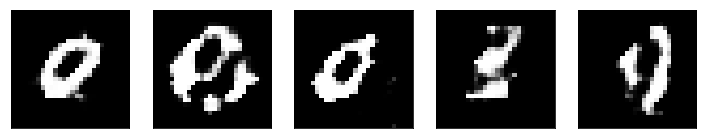

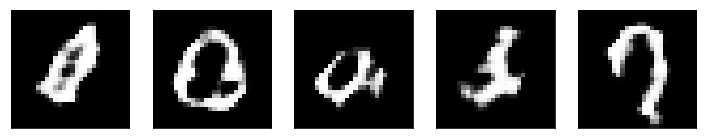

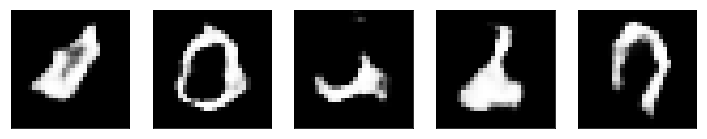

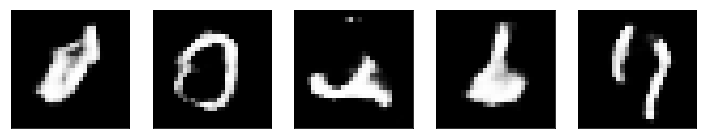

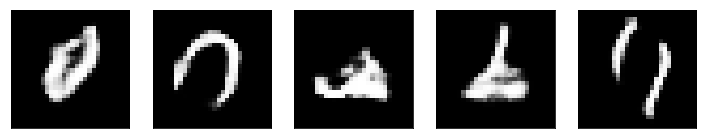

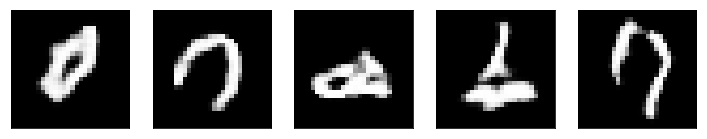

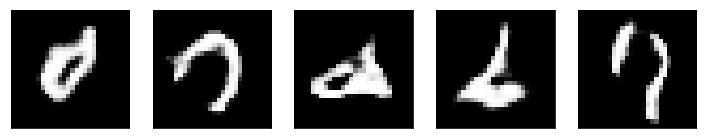

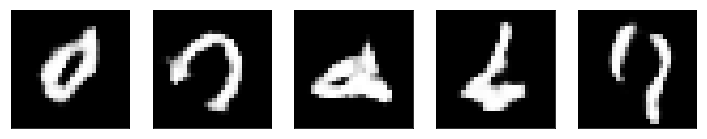

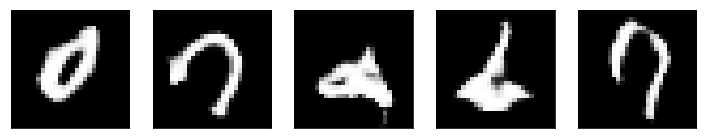

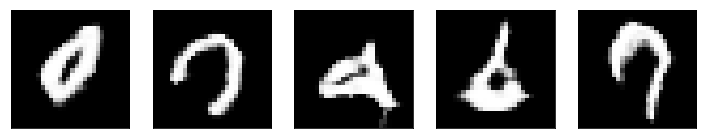

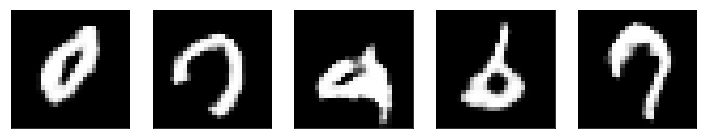

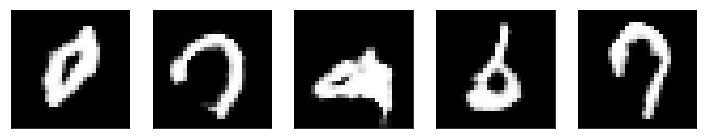

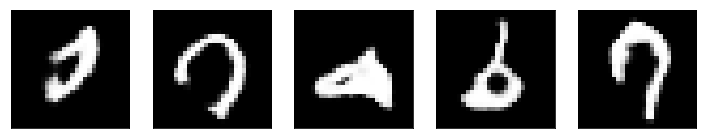

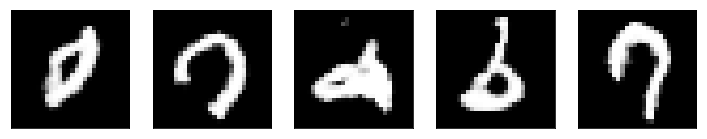

In [137]:
train('shallow_latent_dim_200', generator, discriminator, gan_model, X_mnist_train[:20000], latent_dim=200, n_epochs=70)

Initialized Tensorboard with logdir=tf_logs/wide_latent_dim_20


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


...............................................................................................1, d_loss=0.7074732184410095, d_acc=0.48046875, gan=loss: 0.7057183384895325, acc: 0.44921875, val_loss: 0.7121768593788147, val_acc: 0.30859375
epoch over, writing callbacks
...............................................................................................2, d_loss=0.7004520297050476, d_acc=0.48046875, gan=loss: 0.6968110203742981, acc: 0.48828125, val_loss: 0.6842264533042908, val_acc: 0.59375
epoch over, writing callbacks
...............................................................................................3, d_loss=0.697120189666748, d_acc=0.48046875, gan=loss: 0.7088825702667236, acc: 0.390625, val_loss: 0.7009682655334473, val_acc: 0.46875
epoch over, writing callbacks
...............................................................................................4, d_loss=0.6968259811401367, d_acc=0.44921875, gan=loss: 0.6834203004837036, acc: 0.62109375, val_loss:

...............................................................................................32, d_loss=0.6924256086349487, d_acc=0.53125, gan=loss: 0.6922485828399658, acc: 0.56640625, val_loss: 0.6939004063606262, val_acc: 0.4140625
epoch over, writing callbacks
...............................................................................................33, d_loss=0.6906917095184326, d_acc=0.53125, gan=loss: 0.6968196034431458, acc: 0.4453125, val_loss: 0.7011170983314514, val_acc: 0.15625
epoch over, writing callbacks
...............................................................................................34, d_loss=0.6929245591163635, d_acc=0.52734375, gan=loss: 0.7095544338226318, acc: 0.2890625, val_loss: 0.7094128727912903, val_acc: 0.00390625
epoch over, writing callbacks
...............................................................................................35, d_loss=0.693712055683136, d_acc=0.5, gan=loss: 0.6995702981948853, acc: 0.44140625, val_loss: 0.7005

...............................................................................................63, d_loss=0.692776620388031, d_acc=0.51953125, gan=loss: 0.6905882954597473, acc: 0.5625, val_loss: 0.6959860920906067, val_acc: 0.30859375
epoch over, writing callbacks
...............................................................................................64, d_loss=0.6927358508110046, d_acc=0.5390625, gan=loss: 0.6955206990242004, acc: 0.42578125, val_loss: 0.7011715769767761, val_acc: 0.05859375
epoch over, writing callbacks
...............................................................................................65, d_loss=0.6916909217834473, d_acc=0.58203125, gan=loss: 0.6972963809967041, acc: 0.4375, val_loss: 0.7021770477294922, val_acc: 0.03515625
epoch over, writing callbacks
...............................................................................................66, d_loss=0.6912697553634644, d_acc=0.5390625, gan=loss: 0.6882323622703552, acc: 0.60546875, val_los

...............................................................................................24, d_loss=0.6861240267753601, d_acc=0.5859375, gan=loss: 0.6787416934967041, acc: 0.65625, val_loss: 0.673707127571106, val_acc: 0.96875
epoch over, writing callbacks
...............................................................................................25, d_loss=0.689516007900238, d_acc=0.5625, gan=loss: 0.7037146687507629, acc: 0.40234375, val_loss: 0.6983556151390076, val_acc: 0.3515625
epoch over, writing callbacks
...............................................................................................26, d_loss=0.6908137798309326, d_acc=0.50390625, gan=loss: 0.6942533254623413, acc: 0.50390625, val_loss: 0.6856817007064819, val_acc: 0.75390625
epoch over, writing callbacks
...............................................................................................27, d_loss=0.6903645396232605, d_acc=0.5234375, gan=loss: 0.7069005370140076, acc: 0.39453125, val_loss: 0

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


...............................................................................................36, d_loss=0.693760871887207, d_acc=0.515625, gan=loss: 0.6880801320075989, acc: 0.53125, val_loss: 0.6814823746681213, val_acc: 0.82421875
epoch over, writing callbacks
...............................................................................................37, d_loss=0.6963589787483215, d_acc=0.48046875, gan=loss: 0.6941350102424622, acc: 0.48828125, val_loss: 0.6886868476867676, val_acc: 0.6640625
epoch over, writing callbacks
...............................................................................................38, d_loss=0.6924150586128235, d_acc=0.54296875, gan=loss: 0.6951812505722046, acc: 0.45703125, val_loss: 0.6912883520126343, val_acc: 0.59375
epoch over, writing callbacks
...............................................................................................39, d_loss=0.6942932605743408, d_acc=0.5234375, gan=loss: 0.695418655872345, acc: 0.5234375, val_loss:

...............................................................................................67, d_loss=0.6937143802642822, d_acc=0.515625, gan=loss: 0.6998322606086731, acc: 0.43359375, val_loss: 0.7032594084739685, val_acc: 0.06640625
epoch over, writing callbacks
...............................................................................................68, d_loss=0.6922802329063416, d_acc=0.51953125, gan=loss: 0.703911304473877, acc: 0.40625, val_loss: 0.7084351778030396, val_acc: 0.0234375
epoch over, writing callbacks
...............................................................................................69, d_loss=0.6934609413146973, d_acc=0.4765625, gan=loss: 0.6923074126243591, acc: 0.54296875, val_loss: 0.6934435367584229, val_acc: 0.46875
epoch over, writing callbacks
...............................................................................................70, d_loss=0.6923152804374695, d_acc=0.5546875, gan=loss: 0.697050154209137, acc: 0.45703125, val_loss:

...............................................................................................27, d_loss=0.6904236078262329, d_acc=0.5390625, gan=loss: 0.6924784779548645, acc: 0.51171875, val_loss: 0.6965847015380859, val_acc: 0.35546875
epoch over, writing callbacks
...............................................................................................28, d_loss=0.6882078051567078, d_acc=0.51953125, gan=loss: 0.7051402926445007, acc: 0.36328125, val_loss: 0.7125876545906067, val_acc: 0.0078125
epoch over, writing callbacks
...............................................................................................29, d_loss=0.6943212747573853, d_acc=0.46484375, gan=loss: 0.6854708194732666, acc: 0.62890625, val_loss: 0.6964955925941467, val_acc: 0.34375
epoch over, writing callbacks
...............................................................................................30, d_loss=0.6908486485481262, d_acc=0.53125, gan=loss: 0.6941854953765869, acc: 0.4609375, val_l

...............................................................................................58, d_loss=0.6931607723236084, d_acc=0.51171875, gan=loss: 0.7012441754341125, acc: 0.42578125, val_loss: 0.716185986995697, val_acc: 0.02734375
epoch over, writing callbacks
...............................................................................................59, d_loss=0.6916913986206055, d_acc=0.53125, gan=loss: 0.7014572024345398, acc: 0.45703125, val_loss: 0.7191034555435181, val_acc: 0.0234375
epoch over, writing callbacks
...............................................................................................60, d_loss=0.691215991973877, d_acc=0.51171875, gan=loss: 0.6852380633354187, acc: 0.578125, val_loss: 0.7091942429542542, val_acc: 0.09375
epoch over, writing callbacks
...............................................................................................61, d_loss=0.688295304775238, d_acc=0.546875, gan=loss: 0.6832846403121948, acc: 0.60546875, val_loss: 

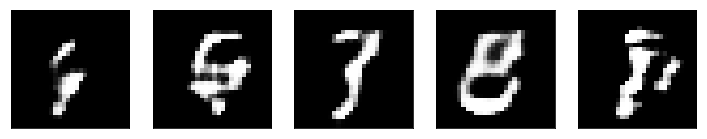

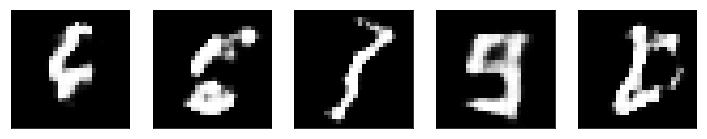

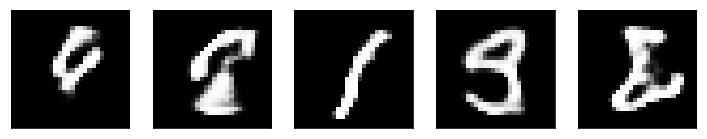

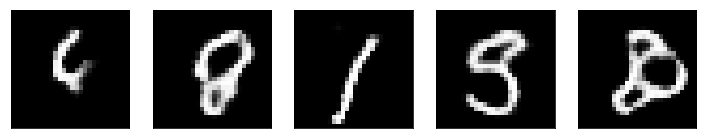

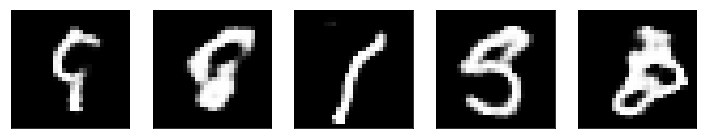

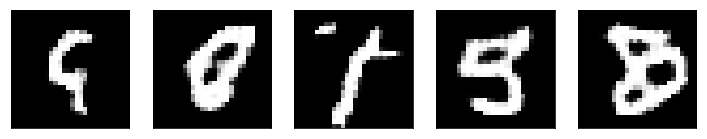

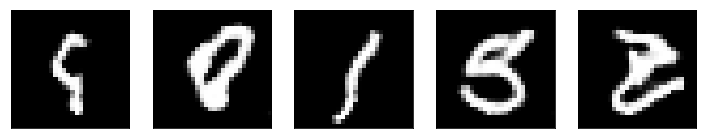

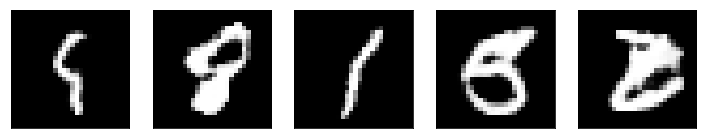

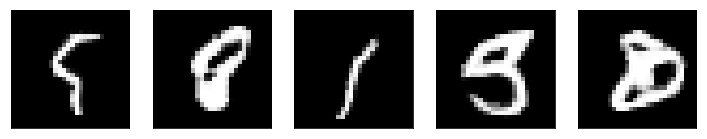

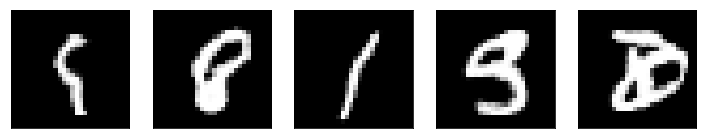

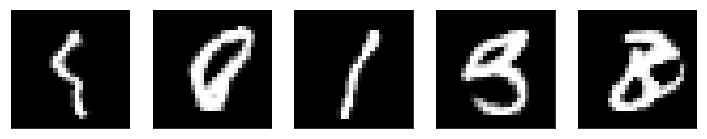

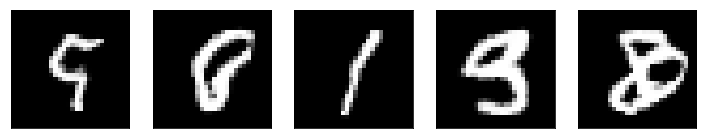

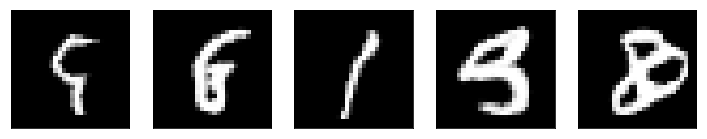

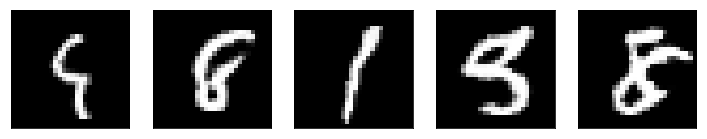

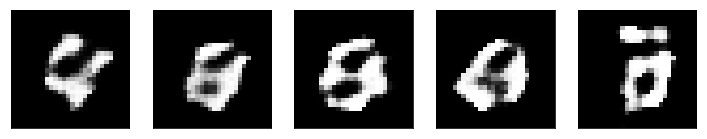

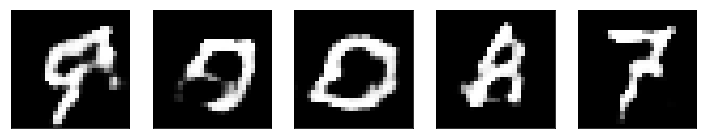

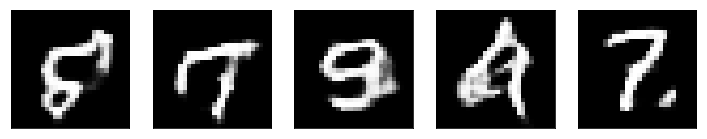

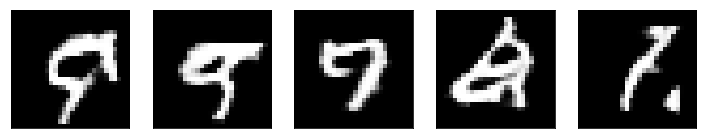

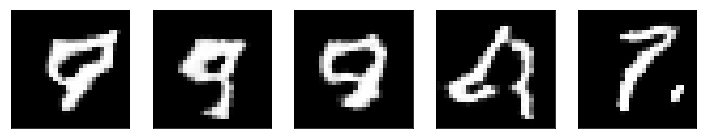

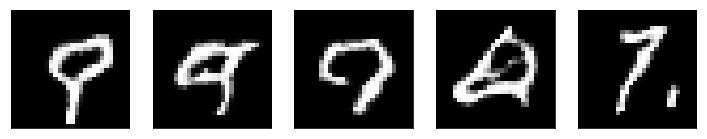

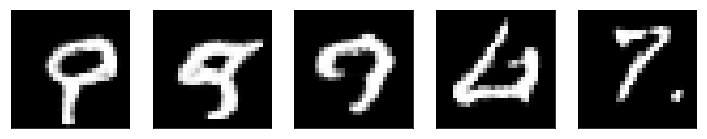

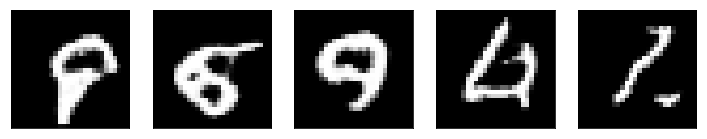

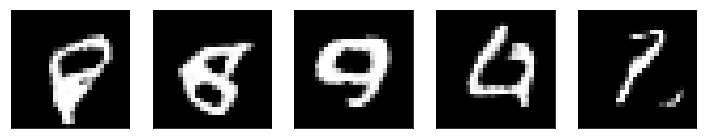

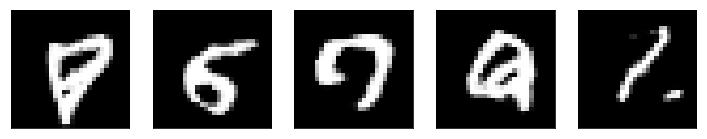

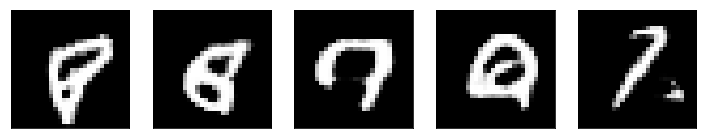

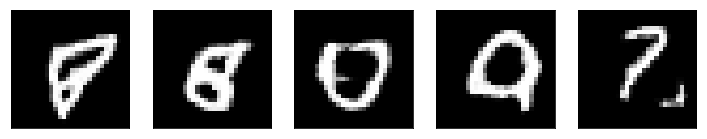

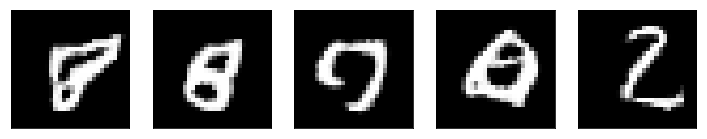

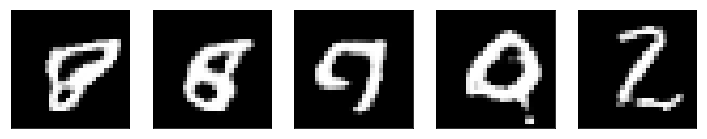

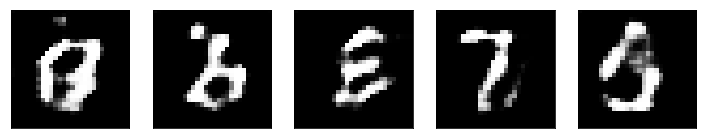

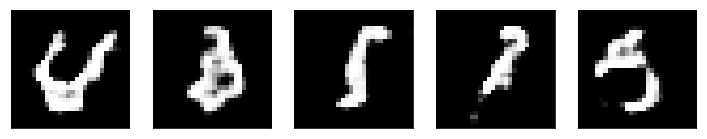

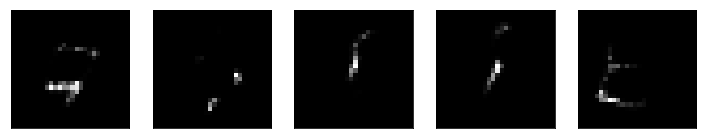

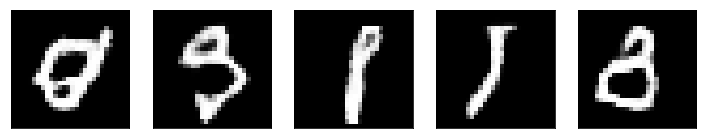

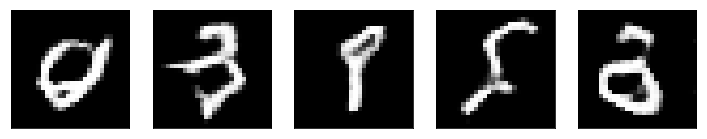

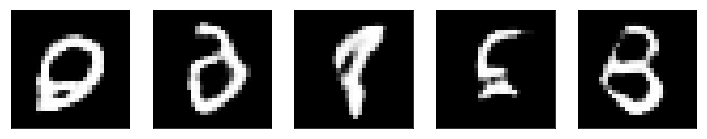

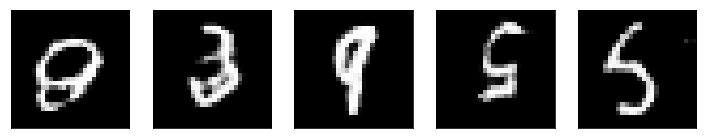

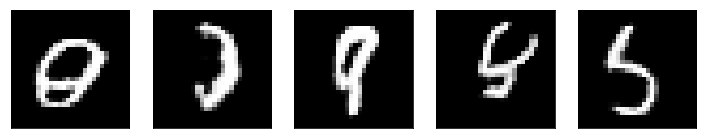

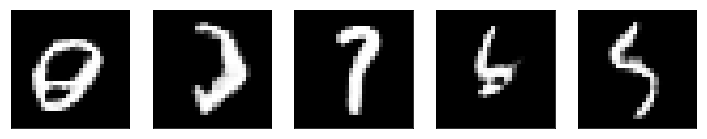

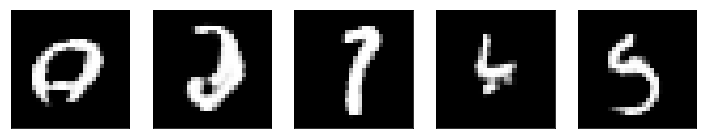

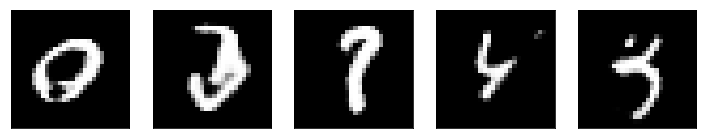

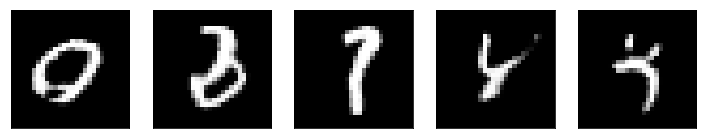

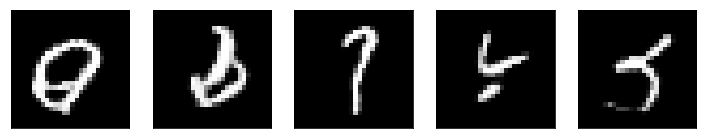

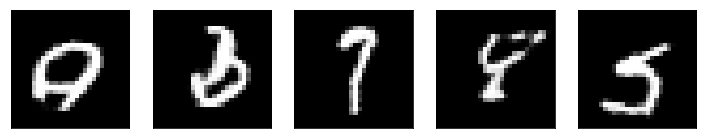

In [139]:
for dims in [20, 100, 200]:
    discriminator = discriminator_model()
    generator = wide_generator_model(dims)
    gan_model = define_gan(generator, discriminator)
    
    train(f'wide_latent_dim_{dims}', generator, discriminator, gan_model, X_mnist_train[:20000], latent_dim=dims, n_epochs=70)

In [119]:
# https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/
# Obavezno ukljuciti u MNIST barem 10000 primjera za učenje za efektivno učenje

In [72]:
print(tf.__version__)

1.6.0
